In [140]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


In [141]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [142]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [143]:
## get data
(x_train,y_train),(x_test,y_test) = mnist.load_data()

In [144]:
## normalise data
x_train = (x_train.astype('float32')-127.5)  /127.5
x_test = (x_test.astype('float32')-127.5)  /127.5

images = np.concatenate( [x_train,x_test])

In [145]:
def make_generator_model(latent_vector_size=100):
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_vector_size,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    layers.Conv2D(256, (4,4), padding='same',strides=(1,1)),
    layers.LeakyReLU(),

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    layers.Conv2D(128, (3,3), padding='same',strides=(1,1)),
    layers.LeakyReLU(),



    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [146]:
## discriminator model
def make_discriminator_model():
  discriminator = Sequential ([
      layers.Conv2D(64, (4,4), input_shape=[28,28,1],padding='same',strides=(2,2)),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Conv2D(128, (4,4), strides=(2,2),padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.Dense(1)

  ])
  return discriminator

In [147]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss( real_output , fake_output ):

  real_loss = cross_entropy( tf.ones_like(real_output ), real_output)

  fake_loss = cross_entropy( tf.zeros_like( fake_output ), fake_output)

  return real_loss + fake_loss


def generator_loss ( fake_output):
  return cross_entropy ( tf.ones_like( fake_output), fake_output)

In [148]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [149]:
checkpoint_dir = './drive/MyDrive/GANS/mnist/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [150]:
@tf.function
def train_step(images):

  noise = tf.random.normal(  [batch_size, noise_dim])

  ## train discriminator for k steps first, in order to let it get ahead of generator
  for k in range(5):
    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      disc_loss = discriminator_loss(real_output,fake_output)

    ## calculate gradient of discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    ## apply gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


  with tf.GradientTape() as gen_tape:
      generated_images = generator(noise, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)

  ## calculate gradient of discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  ## apply gradients
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [151]:
def train (dataset, epochs  ):
  for epoch in range(epochs):
    start = time.time()

    for batch in dataset:
      train_step( batch )

      # Save the model every 15 epochs
    if (epoch + 1) % 30 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('Saved At Checkpoint')

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


In [152]:
epochs = 60
noise_dim = 8
batch_size = 128
buffer_size = 70000

# batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

generator= make_generator_model(latent_vector_size=noise_dim)
discriminator = make_discriminator_model()

In [153]:
train ( train_dataset, epochs)

Time for epoch 1 is 41.955997467041016 sec
Time for epoch 2 is 33.035178422927856 sec
Time for epoch 3 is 32.43982648849487 sec
Time for epoch 4 is 32.706997871398926 sec
Time for epoch 5 is 32.71799969673157 sec
Time for epoch 6 is 32.606693983078 sec
Time for epoch 7 is 32.60512018203735 sec
Time for epoch 8 is 32.598090410232544 sec
Time for epoch 9 is 32.716230154037476 sec
Time for epoch 10 is 32.688552141189575 sec
Time for epoch 11 is 32.642643213272095 sec
Time for epoch 12 is 32.61276197433472 sec
Time for epoch 13 is 32.745545387268066 sec
Time for epoch 14 is 32.74663734436035 sec
Time for epoch 15 is 32.6513512134552 sec
Time for epoch 16 is 32.6789927482605 sec
Time for epoch 17 is 32.714073181152344 sec
Time for epoch 18 is 32.718583822250366 sec
Time for epoch 19 is 32.715909242630005 sec
Time for epoch 20 is 32.690837383270264 sec
Time for epoch 21 is 32.722490549087524 sec
Time for epoch 22 is 32.698795795440674 sec
Time for epoch 23 is 32.72039079666138 sec
Time for e

In [154]:
generator.save('./drive/MyDrive/GANS/mnist/Models/60epochs_k=5_latent_vector=8_model.keras')

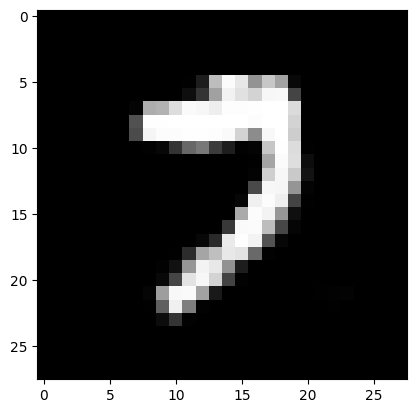

In [229]:
# @title Inputs { run: "auto", form-width: "300px", display-mode: "form" }
input = np.ones(shape=(1,10))
i0 = 0  #@param {type:"slider", min:-3, max:3, step:0.05}
i1 = -0.05  #@param {type:"slider", min:-3, max:3, step:0.05}
i2 = -2.2  #@param {type:"slider", min:-3, max:3, step:0.05}
i3 = 2.85  #@param {type:"slider", min:-3, max:3, step:0.05}
i4 = -1.1  #@param {type:"slider", min:-3, max:3, step:0.05}
i5 = 0  #@param {type:"slider", min:-3, max:3, step:0.05}
i6 = 0  #@param {type:"slider", min:-3, max:3, step:0.05}
i7 = 0#@param {type:"slider", min:-3, max:3, step:0.05}
# i8 = 2.55#@param {type:"slider", min:-3, max:3, step:0.05}
# i9 = -2.6#@param {type:"slider", min:-3, max:3, step:0.05}


buffer =np.array([i0,i1,i2,i3,i4,i4,i5,i6,i7])##,i8,i9])#,dtype=float)

input = np.ndarray(shape=(1,8),buffer=buffer)
image = generator( input)
plt.imshow( image[0,:,:,0],cmap='gray'  )